## Raytracing speedup

The great advantage of pyC$^2$Ray is that the re-written raytracing algorithm (ASORA) employ GPU which can speedup calculation.

The algorithm has been tested on a series of NVIDIA GPUs commonly used on HPC and one laptop GPU graphic card and present the following speedup, when compare to the python CPU version:

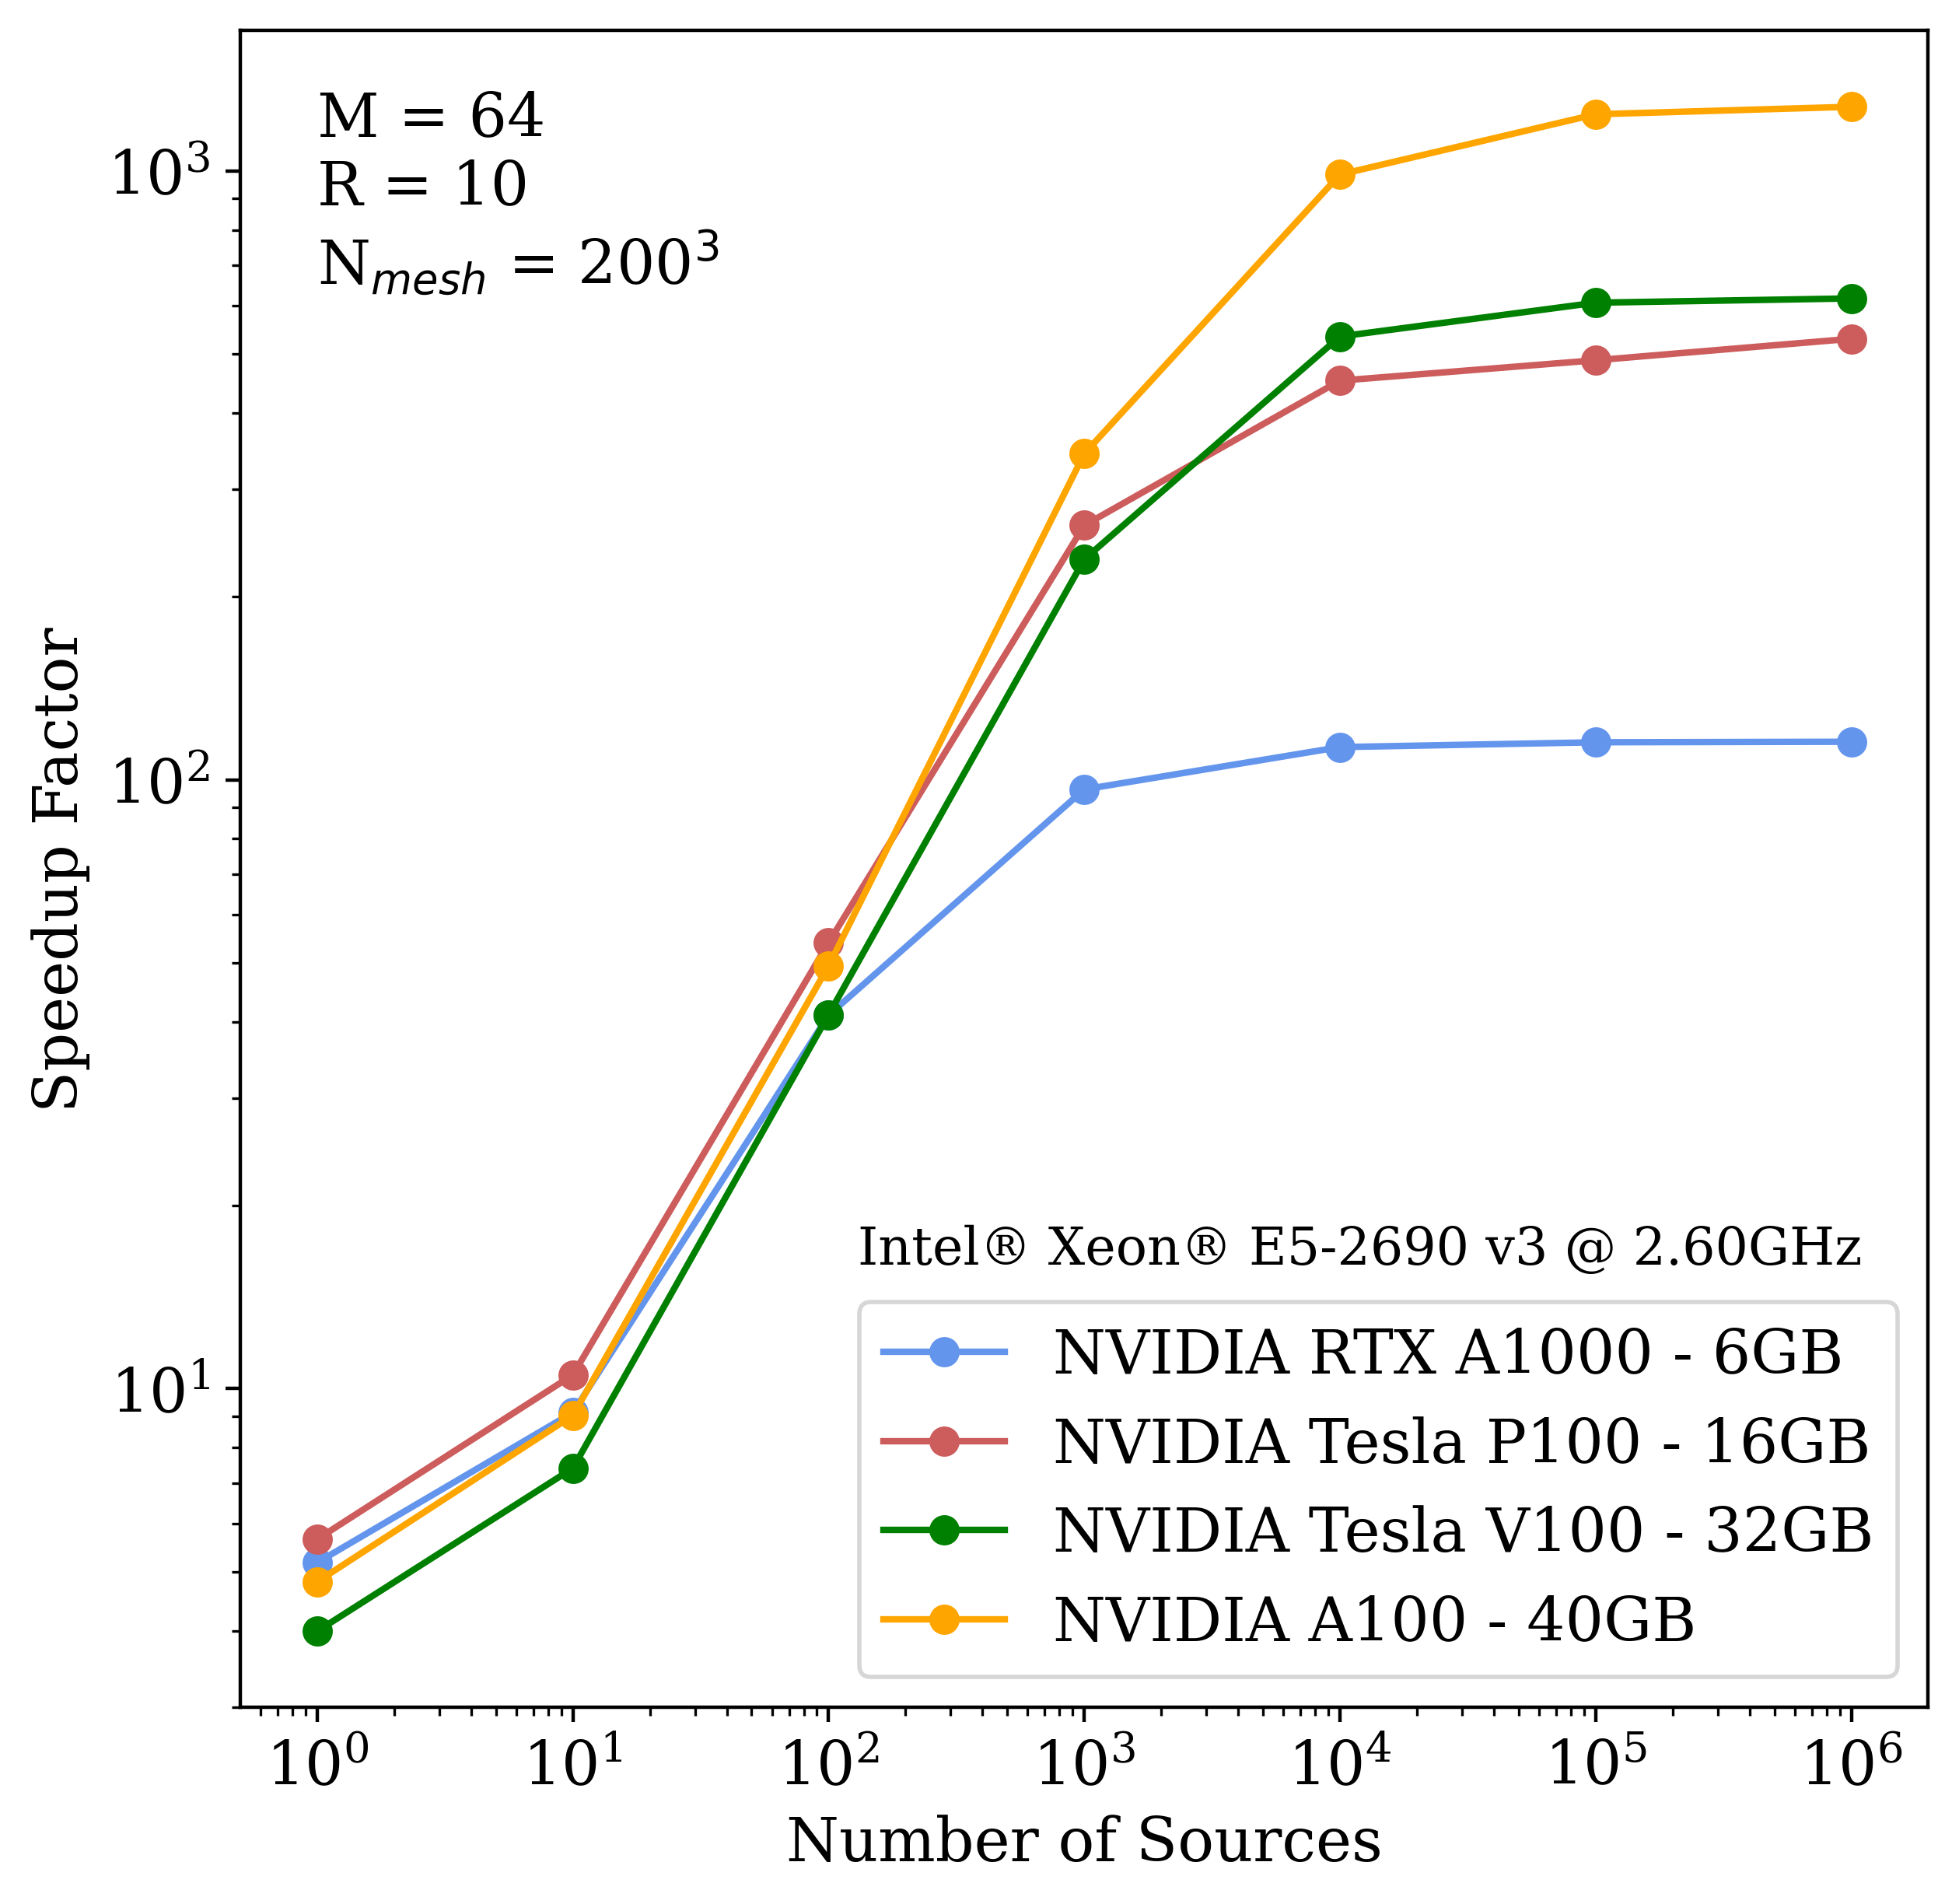

In [1]:
from IPython.display import Image, display
display(Image('../fig/speedup_sources_GPUs.png', width=500))

## GPU memory usage

However, we are often limited by the GPU memory. Therefore to help you setup you simulation and undestand its memory usage of your can estimate it by the following equation:

$$ \mathrm{GPU\,memory\,[GB]} = \left[3\,N_\mathrm{mesh\,size}^3 + \left(\sqrt{2} R \right)^3\right] \cdot M \cdot 4\,N_\mathrm{src} \cdot 8\,/\,10^9$$

Most of the variables employed by pyC$^2$Ray are defined in a YAML file, e.g. `parameters.yml` and can be access from the notebook with the following: 

In [3]:
import pyc2ray as pc2r
import numpy as np, yaml
import matplotlib.pyplot as plt

In [23]:
def memory_usage(paramfile, Nsrc):
    with open(paramfile,'r') as f:
        params = yaml.load(f, yaml.CSafeLoader)
    
    Nmesh = params['Grid']['meshsize']
    R = params['Sinks']['R_max_cMpc']/params['Grid']['boxsize']*params['Grid']['meshsize']*params['Cosmology']['h']
    if(R>Nmesh):
        R = Nmesh
    M = params['Raytracing']['source_batch_size']
    mem_us = ((3*Nmesh**3 + (np.sqrt(2)*R)**3)*M+4*Nsrc)*8/1e9
    
    print('Memory usage (N_src=%.0e): %.3f GB' %(Nsrc, mem_us))
    
paramfile = 'parameters.yml'

memory_usage(paramfile=paramfile, Nsrc=1e6)

Memory usage (N_src=1e+06): 0.130 GB


[  1.   2.   4.   8.  16.  32.  64. 128.]


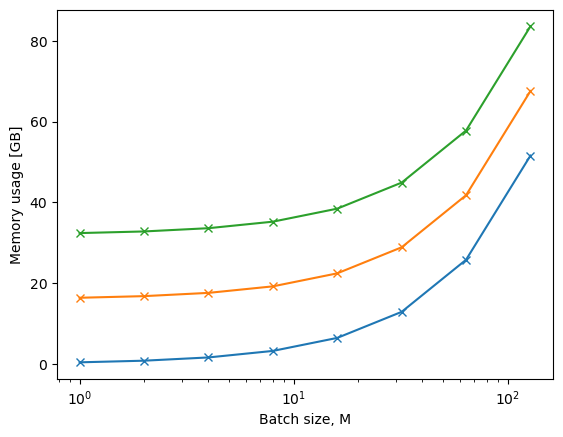

(None, None)

<Figure size 640x480 with 0 Axes>

In [50]:
Nmesh = 256
M = 2**np.linspace(0, 7, 8)
R = 10
print(M)

for Nsrc in [1e6, 5e8, 1e9]:
    mem_us = ((3*Nmesh**3 + (np.sqrt(2)*R)**3)*M+4*Nsrc)*8/1e9

    plt.semilogx(M, mem_us, 'x-')
    plt.xlabel('Batch size, M'), plt.ylabel('Memory usage [GB]')

plt.show(), plt.clf()